In [22]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install -q safetensors

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import os
import torch.nn.functional as F
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [25]:
#%pip install -q safetensors

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# 1) Load model & processor
model_id = "openai/clip-vit-base-patch32"

# Force safetensors to avoid torch.load() (and the torch>=2.6 restriction / CVE gate)
model = CLIPModel.from_pretrained(model_id, use_safetensors=True)
processor = CLIPProcessor.from_pretrained(model_id)

# 2) Choose device: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    # Print GPU name and count if on CUDA
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 3) Move model to that device
model.to(device)

# 4) Load and preprocess an image
image_path = "Images\\18759-guard301.jpg"
image = Image.open(image_path)

# texts = ["cat", "dog", "car", "fruit bowl", "city", "flower"]
texts = ["Fransesco Guardi", "Picasso", "Van Gogh", "Leonardo da Vinci",
         "Claude Monet", "Salvador Dali", "Rembrandt", "Michelangelo", "Raphael",
         "Caravaggio", "Titian", "El Greco", "Goya", "Vermeer", "Botticelli"]

# 5) Preprocess inputs (still on CPU now)
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

# 6) Move all input tensors to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# 7) Run the model
outputs = model(**inputs)
image_embeddings = outputs.image_embeds
text_embeddings  = outputs.text_embeds

# 8) Compute similarity
import torch.nn.functional as F
similarity_scores = F.cosine_similarity(image_embeddings, text_embeddings)

print("Similarity scores:", similarity_scores)

best_idx = similarity_scores.argmax().item()
print(f"Best match: '{texts[best_idx]}' with score {similarity_scores[best_idx]:.4f}")


Using device: cuda
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4090 Laptop GPU
Similarity scores: tensor([0.3239, 0.2381, 0.2341, 0.2402, 0.1830, 0.2337, 0.2705, 0.2206, 0.2255,
        0.2495, 0.2763, 0.2507, 0.2624, 0.2500, 0.2288], device='cuda:0',
       grad_fn=<SumBackward1>)
Best match: 'Fransesco Guardi' with score 0.3239


## Analysis: Authors with Paintings from Different Time Frames

Let's check if the same author has paintings made in different time frames in the semart_train.csv dataset.

In [29]:
# Load the semart_train.csv file
df_train = pd.read_csv("semart_full_cleaned.csv")

# Display basic info about the dataset
print(f"Total number of paintings: {len(df_train)}")
print(f"\nColumn names: {df_train.columns.tolist()}")
print(f"\nFirst few rows:")
df_train.head()

Total number of paintings: 20798

Column names: ['IMAGE_FILE', 'DESCRIPTION', 'AUTHOR', 'TITLE', 'TECHNIQUE', 'DATE', 'TYPE', 'SCHOOL', 'TIMEFRAME']

First few rows:


,IMAGE_FILE,DESCRIPTION,AUTHOR,TITLE,TECHNIQUE,DATE,TYPE,SCHOOL,TIMEFRAME
0,19873-1darmst.jpg,"The Meyer or Darmstadt Madonna is the last, mo...","HOLBEIN, Hans the Younger",Darmstadt Madonna,"Oil on limewood, 147 x 102 cm",1526 and after 1528,religious,German,1501-1550
1,18759-guard301.jpg,Whereas Canaletto incorporates classically ins...,"GUARDI, Francesco",Landscape with a Fisherman's Tent,"Oil on canvas, 49 x 77 cm",1770-75,landscape,Italian,1751-1800
2,04589-temptati.jpg,In this painting the refinement of the colouri...,"BILIVERT, Giovanni",The Temptation of Charles and Ubalde,"Oil on copper, 37 x 28 cm",1629-30,religious,Italian,1601-1650
3,15104-magi.jpg,"The left side of the painting was cut, origina...",GEERTGEN tot Sint Jans,Adoration of the Magi,"Panel, 111 x 69 cm",1480-85,religious,Netherlandish,1451-1500
4,36582-paolo_f1.jpg,The painting illustrates a famous episode from...,"SCHEFFER, Ary",The Ghosts of Paolo and Francesca Appear to Da...,"Oil on canvas, 167 x 234 cm",1835,other,Dutch,1801-1850


## Author Prediction Using CLIP

Using the same CLIP similarity logic, let's predict the author of 10 random paintings by comparing each image against all authors in the dataset.

In [30]:
# Get all unique authors from the dataset
all_authors = df_train['AUTHOR'].unique().tolist()
print(f"Total number of unique authors in dataset: {len(all_authors)}")

# Select 10 random paintings from the dataset
import random
random.seed(42)  # For reproducibility
sample_paintings = df_train.sample(n=10, random_state=42)

print(f"\nSelected {len(sample_paintings)} random paintings for prediction:")
sample_paintings[['IMAGE_FILE', 'AUTHOR', 'TITLE', 'DATE']].head(10)

Total number of unique authors in dataset: 3253

Selected 10 random paintings for prediction:


,IMAGE_FILE,AUTHOR,TITLE,DATE
1346,23997-zeno01.jpg,"MANTEGNA, Andrea",San Zeno Polyptych,1457-60
14568,26132-36ursu02.jpg,"MEMLING, Hans",St Ursula Shrine: Arrival in Basel (scene 2),1489
14700,30424-rocca7.jpg,PARMIGIANINO,Diana and Actaeon,1523-24
10881,03305-predell2.jpg,BARTOLOMEO DI GIOVANNI,Predella: Annunciation,1488
16459,15163-09quarat.jpg,GENTILE DA FABRIANO,Quaratesi Polyptych: The Birth of St Nicholas,1425
7476,20742-satyr_pa.jpg,"JORDAENS, Jacob",The Satyr and the Peasant,c. 1620
4186,44273-4rome.jpg,"WITTEL, Caspar Andriaans van",Rome: View of the River Tiber with the Ponte R...,1680s
18800,02896-preachin.jpg,BACICCIO,The Preaching of St John the Baptist,c. 1690
12092,08583-4bather3.jpg,"CÉZANNE, Paul",The Large Bathers,1898-1905
1710,00613-02crucif.jpg,ANDREA DEL CASTAGNO,Crucifixion,c. 1450


In [31]:
# Function to predict author for a given image
def predict_author_for_image(image_path, authors_list, model, processor, device):
    """
    Predict the author of a painting using CLIP similarity
    """
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        
        # Preprocess inputs
        inputs = processor(text=authors_list, images=image, return_tensors="pt", padding=True)
        
        # Move all input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run the model
        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds
        
        # Compute similarity
        similarity_scores = F.cosine_similarity(image_embeddings, text_embeddings)
        
        # Get best match
        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()
        
        # Get top 5 matches
        top5_indices = similarity_scores.argsort(descending=True)[:5]
        top5_matches = [(authors_list[idx], similarity_scores[idx].item()) for idx in top5_indices]
        
        return best_author, best_score, top5_matches
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

print("Function defined successfully!")

Function defined successfully!


## Author Prediction for Top 100 Most Prolific Artists

Let's improve prediction accuracy by focusing on the 100 authors with the most paintings in the dataset (excluding Unknown artists).

In [32]:
# Find the top 100 authors with the most paintings (excluding Unknown artists)
author_counts = df_train['AUTHOR'].value_counts()

# Filter out authors with "Unknown" in their name
author_counts_filtered = author_counts[~author_counts.index.str.contains('Unknown', case=False, na=False)]
top_100_authors = author_counts_filtered.head(100).index.tolist()

print(f"Top 100 authors with most paintings (excluding Unknown artists):")
print("="*80)
for i, author in enumerate(top_100_authors, 1):
    count = author_counts[author]
    print(f"{i:3d}. {author:40s} - {count:3d} paintings")

Top 100 authors with most paintings (excluding Unknown artists):
  1. GOGH, Vincent van                        - 327 paintings
  2. REMBRANDT Harmenszoon van Rijn           - 262 paintings
  3. GIOTTO di Bondone                        - 249 paintings
  4. RUBENS, Peter Paul                       - 213 paintings
  5. TIZIANO Vecellio                         - 205 paintings
  6. GRECO, El                                - 192 paintings
  7. CRANACH, Lucas the Elder                 - 190 paintings
  8. VERONESE, Paolo                          - 187 paintings
  9. TINTORETTO                               - 178 paintings
 10. TIEPOLO, Giovanni Battista               - 178 paintings
 11. RAFFAELLO Sanzio                         - 177 paintings
 12. ANGELICO, Fra                            - 166 paintings
 13. MEMLING, Hans                            - 140 paintings
 14. MICHELANGELO Buonarroti                  - 135 paintings
 15. MANTEGNA, Andrea                         - 126 paintings
 16. 

In [33]:
# Use ALL paintings from the top 100 authors
paintings_top100 = df_train[df_train['AUTHOR'].isin(top_100_authors)]

print(f"Total paintings by top 100 authors: {len(paintings_top100)}")
print(f"\nWill predict authors for all {len(paintings_top100)} paintings")
print(f"\nFirst 10 paintings:")
paintings_top100[['IMAGE_FILE', 'AUTHOR', 'TITLE', 'DATE']].head(10)

Total paintings by top 100 authors: 7913

Will predict authors for all 7913 paintings

First 10 paintings:


,IMAGE_FILE,AUTHOR,TITLE,DATE
0,19873-1darmst.jpg,"HOLBEIN, Hans the Younger",Darmstadt Madonna,1526 and after 1528
1,18759-guard301.jpg,"GUARDI, Francesco",Landscape with a Fisherman's Tent,1770-75
5,00930-30coron.jpg,"ANGELICO, Fra",The Coronation of the Virgin,1434-35
7,18424-2105grec.jpg,"GRECO, El",Portrait of Cardinal Tavera,1608-14
8,21949-4lastsu3.jpg,LEONARDO da Vinci,The Last Supper,1498
13,39738-04organ.jpg,TIZIANO Vecellio,Venus and Cupid with an Organist,1548-49
17,12035-painstud.jpg,"DOU, Gerrit",Painter in his Studio,1647
20,20109-44hooch.jpg,"HOOCH, Pieter de",Woman Reading a Letter,1664
21,09651-03barber.jpg,"CORTONA, Pietro da",Ceiling vault (centre part),1633-39
22,12270-verso14.jpg,DUCCIO di Buoninsegna,Christ Before King Herod (scene 14),1308-11


In [34]:
# Predict authors for ALL paintings by top 100 authors (using only top 100 authors as candidates)
top100_results = []

print(f"Predicting authors for all {len(paintings_top100)} paintings (Top 100 authors only)...\n")
print("="*100)

total_paintings = len(paintings_top100)
for counter, (idx, row) in enumerate(paintings_top100.iterrows(), 1):
    
    image_file = row['IMAGE_FILE']
    true_author = row['AUTHOR']
    title = row['TITLE']
    image_path = os.path.join("Images", image_file)
    
    
    # Show progress every 100 paintings or for first 10
    if counter <= 10 or counter % 100 == 0:
        print(f"\n[{counter}/{total_paintings}] Processing: {title} by {true_author}")
    
    # Predict author using only top 100 authors
    predicted_author, confidence, top5_matches = predict_author_for_image(
        image_path, top_100_authors, model, processor, device
    )
    
    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"
        
        print(f"   {symbol} Predicted Author: {predicted_author} (confidence: {confidence:.4f})")
        # Only show detailed predictions for first 10 or every 100th painting
        if counter <= 10 or counter % 100 == 0:
            print(f"   {symbol} Predicted: {predicted_author} (confidence: {confidence:.4f})")
            if not is_correct:
                print(f"      Top 5: {', '.join([f'{a} ({s:.3f})' for a, s in top5_matches[:5]])}")
        top100_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'predicted_author': predicted_author,
            'confidence': confidence,
            'correct': is_correct
        })
    

print(f"\n\nPrediction complete!")

Predicting authors for all 7913 paintings (Top 100 authors only)...


[1/7913] Processing: Darmstadt Madonna by HOLBEIN, Hans the Younger
   ❌ Predicted Author: LIPPI, Filippino (confidence: 0.2912)
   ❌ Predicted: LIPPI, Filippino (confidence: 0.2912)
      Top 5: LIPPI, Filippino (0.291), LIPPI, Fra Filippo (0.291), ANGELICO, Fra (0.283), PINTURICCHIO (0.281), CRANACH, Lucas the Elder (0.277)

[2/7913] Processing: Landscape with a Fisherman's Tent by GUARDI, Francesco
   ❌ Predicted Author: RUISDAEL, Jacob Isaackszon van (confidence: 0.3487)
   ❌ Predicted: RUISDAEL, Jacob Isaackszon van (confidence: 0.3487)
      Top 5: RUISDAEL, Jacob Isaackszon van (0.349), RUYSDAEL, Salomon van (0.348), GUARDI, Francesco (0.318), CANALETTO (0.317), GOYEN, Jan van (0.305)

[3/7913] Processing: The Coronation of the Virgin by ANGELICO, Fra
   ❌ Predicted Author: SIMONE MARTINI (confidence: 0.2849)
   ❌ Predicted: SIMONE MARTINI (confidence: 0.2849)
      Top 5: SIMONE MARTINI (0.285), GIOTTO di Bon

In [35]:
# Summary of results for top 100 authors
if top100_results:
    
    top100_results_df = pd.DataFrame(top100_results)
    
    print("\n" + "="*100)
    print("SUMMARY OF PREDICTIONS (TOP 100 AUTHORS)")
    print("="*100)
    
    # Basic accuracy
    accuracy = top100_results_df['correct'].sum() / len(top100_results_df) * 100
    print(f"\nTotal paintings processed: {len(top100_results_df)}")
    print(f"Accuracy: {accuracy:.2f}% ({top100_results_df['correct'].sum()}/{len(top100_results_df)} correct predictions)")
    
    # Calculate precision, recall, and F1 score
    y_true = top100_results_df['true_author']
    y_pred = top100_results_df['predicted_author']
    
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\nEvaluation Metrics:")
    print(f"  Macro Average:")
    print(f"    Precision: {precision_macro:.4f}")
    print(f"    Recall:    {recall_macro:.4f}")
    print(f"    F1 Score:  {f1_macro:.4f}")
    print(f"  Weighted Average:")
    print(f"    Precision: {precision_weighted:.4f}")
    print(f"    Recall:    {recall_weighted:.4f}")
    print(f"    F1 Score:  {f1_weighted:.4f}")
    
    print(f"\nConfidence Statistics:")
    print(f"  Average: {top100_results_df['confidence'].mean():.4f}")
    print(f"  Median: {top100_results_df['confidence'].median():.4f}")
    print(f"  Max: {top100_results_df['confidence'].max():.4f}")
    print(f"  Min: {top100_results_df['confidence'].min():.4f}")
    
    # Accuracy by confidence level
    correct_df = top100_results_df[top100_results_df['correct']]
    incorrect_df = top100_results_df[~top100_results_df['correct']]
    
    print(f"\nCorrect predictions by confidence:")
    print(f"  Correct predictions avg confidence: {correct_df['confidence'].mean():.4f}")
    print(f"  Incorrect predictions avg confidence: {incorrect_df['confidence'].mean():.4f}")
    
    # Per-author accuracy (for authors with at least 10 paintings)
    print(f"\nPer-Author Performance (authors with 10+ paintings):")
    author_stats = []
    for author in top100_results_df['true_author'].unique():
        author_data = top100_results_df[top100_results_df['true_author'] == author]
        if len(author_data) >= 10:
            author_accuracy = (author_data['correct'].sum() / len(author_data)) * 100
            author_stats.append({
                'author': author,
                'total': len(author_data),
                'correct': author_data['correct'].sum(),
                'accuracy': author_accuracy
            })
    
    author_stats_df = pd.DataFrame(author_stats).sort_values('accuracy', ascending=False)
    print(f"\nTop 10 Best Performing Authors:")
    for idx, row in author_stats_df.head(10).iterrows():
        print(f"  {row['author']:40s} - {row['accuracy']:.1f}% ({row['correct']}/{row['total']})")
    
    print(f"\nBottom 10 Authors:")
    for idx, row in author_stats_df.tail(10).iterrows():
        print(f"  {row['author']:40s} - {row['accuracy']:.1f}% ({row['correct']}/{row['total']})")
    
    # Most commonly confused authors
    print(f"\nMost Common Prediction Errors (Top 10):")
    errors = top100_results_df[~top100_results_df['correct']]
    
    if len(errors) > 0:
        error_pairs = errors.groupby(['true_author', 'predicted_author']).size().sort_values(ascending=False).head(10)
        for (true_a, pred_a), count in error_pairs.items():
            print(f"  {true_a} → {pred_a}: {count} times")
    
    print("\n\nDetailed Results (first 50 rows):")
    display(top100_results_df[['title', 'true_author', 'predicted_author', 'confidence', 'correct']].head(50))
    
    print("\nLast 20 rows:")
    display(top100_results_df[['title', 'true_author', 'predicted_author', 'confidence', 'correct']].tail(20))
else:
    print("No results to display.")


SUMMARY OF PREDICTIONS (TOP 100 AUTHORS)

Total paintings processed: 7913
Accuracy: 29.56% (2339/7913 correct predictions)

Evaluation Metrics:
  Macro Average:
    Precision: 0.2516
    Recall:    0.2661
    F1 Score:  0.2270
  Weighted Average:
    Precision: 0.3140
    Recall:    0.2956
    F1 Score:  0.2759

Confidence Statistics:
  Average: 0.3136
  Median: 0.3134
  Max: 0.4176
  Min: 0.2048

Correct predictions by confidence:
  Correct predictions avg confidence: 0.3183
  Incorrect predictions avg confidence: 0.3117

Per-Author Performance (authors with 10+ paintings):

Top 10 Best Performing Authors:
  CANALETTO                                - 86.6% (84/97)
  CÉZANNE, Paul                            - 83.3% (70/84)
  VERMEER, Johannes                        - 83.3% (35/42)
  GAUGUIN, Paul                            - 83.1% (74/89)
  RENOIR, Pierre-Auguste                   - 80.4% (45/56)
  CARAVAGGIO                               - 77.9% (74/95)
  FRAGONARD, Jean-Honoré      

,title,true_author,predicted_author,confidence,correct
0,Darmstadt Madonna,"HOLBEIN, Hans the Younger","LIPPI, Filippino",0.291174,False
1,Landscape with a Fisherman's Tent,"GUARDI, Francesco","RUISDAEL, Jacob Isaackszon van",0.348654,False
2,The Coronation of the Virgin,"ANGELICO, Fra",SIMONE MARTINI,0.284946,False
3,Portrait of Cardinal Tavera,"GRECO, El","ZURBARÁN, Francisco de",0.340008,False
4,The Last Supper,LEONARDO da Vinci,PINTURICCHIO,0.306494,False
5,Venus and Cupid with an Organist,TIZIANO Vecellio,TINTORETTO,0.336298,False
6,Painter in his Studio,"DOU, Gerrit",REMBRANDT Harmenszoon van Rijn,0.318203,False
7,Woman Reading a Letter,"HOOCH, Pieter de","VERMEER, Johannes",0.307126,False
8,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",0.304181,True
9,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,0.308452,True



Last 20 rows:


,title,true_author,predicted_author,confidence,correct
7893,San Zeno Polyptych,"MANTEGNA, Andrea",PINTURICCHIO,0.320972,False
7894,Predella panel: The Approval of the New Carmel...,"LORENZETTI, Pietro","GOZZOLI, Benozzo",0.317292,False
7895,Worshippers,"TIEPOLO, Giovanni Battista","LORENZETTI, Pietro",0.313144,False
7896,The Mystic Marriage of St Catherine,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",0.302678,True
7897,Christ on the Cross,"ZURBARÁN, Francisco de",CARAVAGGIO,0.273496,False
7898,The Cure of Folly (Extraction of the Stone of ...,"BOSCH, Hieronymus","BRUEGHEL, Pieter the Younger",0.301648,False
7899,Portrait of a Man,"GOSSART, Jan","BRONZINO, Agnolo",0.327436,False
7900,Madonna with Saints and Members of the Pesaro ...,TIZIANO Vecellio,"TIEPOLO, Giovanni Battista",0.313979,False
7901,St Sebastian,"RENI, Guido",CARAVAGGIO,0.314920,False
7902,The Women of Darius's Family before Alexander ...,"SODOMA, Il","PERUGINO, Pietro",0.308332,False


In [36]:
top100_results_df.to_csv("top100_results_df.csv", index=False)
author_stats_df.to_csv("author_stats_df.csv", index=False)

## Apply Grayscale Transformation Using PyTorch

Let's select a random painting and apply grayscale transformation using PyTorch.

Selected painting: San Zeno Polyptych
Author: MANTEGNA, Andrea
File: 23997-zeno01.jpg

Original image shape: torch.Size([3, 1256, 1000])
Image size: (1000, 1256)
Grayscale tensor shape: torch.Size([1, 1256, 1000])


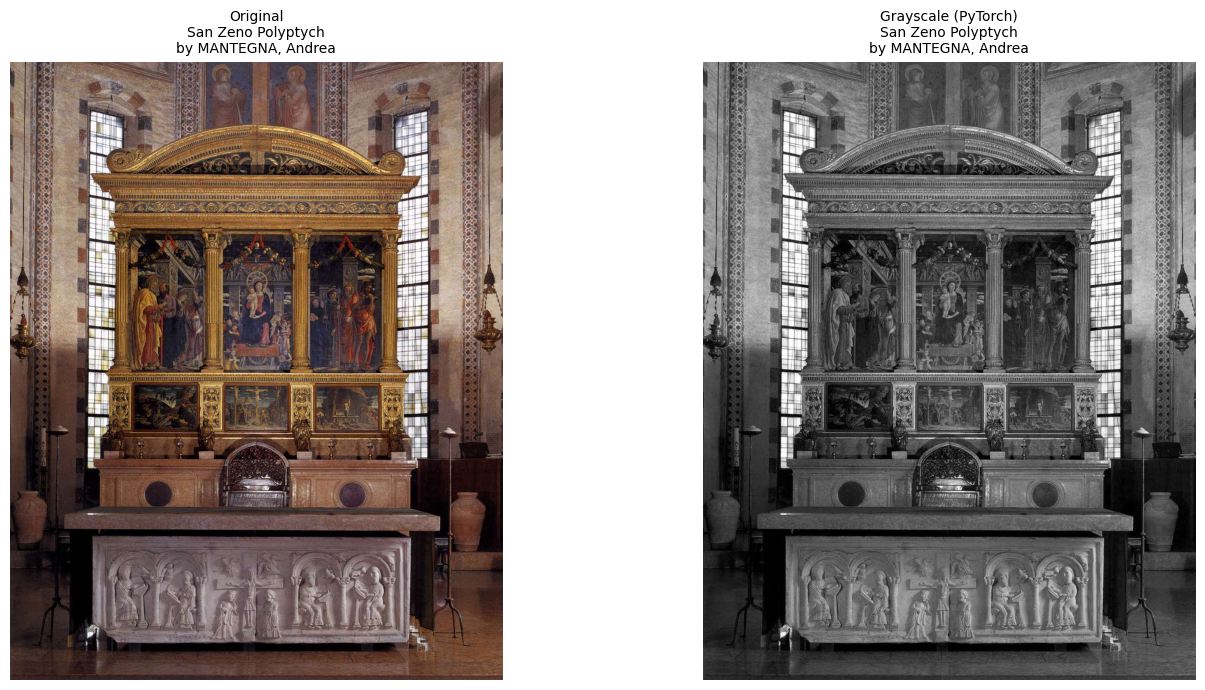


Grayscale transformation applied successfully using PyTorch!


In [37]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch

# Select a random painting from the dataset
random_painting = df_train.sample(n=1, random_state=42)
image_file = random_painting['IMAGE_FILE'].values[0]
title = random_painting['TITLE'].values[0]
author = random_painting['AUTHOR'].values[0]
image_path = os.path.join("Images", image_file)

print(f"Selected painting: {title}")
print(f"Author: {author}")
print(f"File: {image_file}")

# Load the image
original_image = Image.open(image_path)

# Convert PIL Image to PyTorch tensor
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(original_image)

print(f"\nOriginal image shape: {image_tensor.shape}")  # Should be [C, H, W]
print(f"Image size: {original_image.size}")

# Apply grayscale transformation using PyTorch
# Method 1: Using torchvision transforms
grayscale_transform = transforms.Grayscale(num_output_channels=1)
grayscale_tensor = grayscale_transform(original_image)
grayscale_tensor = to_tensor(grayscale_tensor)

print(f"Grayscale tensor shape: {grayscale_tensor.shape}")  # Should be [1, H, W]

# Convert tensors back to images for display
to_pil = transforms.ToPILImage()
grayscale_image = to_pil(grayscale_tensor)

# Display original and grayscale images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(original_image)
axes[0].set_title(f'Original\n{title}\nby {author}', fontsize=10)
axes[0].axis('off')

axes[1].imshow(grayscale_image, cmap='gray')
axes[1].set_title(f'Grayscale (PyTorch)\n{title}\nby {author}', fontsize=10)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\nGrayscale transformation applied successfully using PyTorch!")

## Re-predict Authors on Grayscale Images

Let's take all the paintings where the author was correctly predicted and apply grayscale transformation to them, then re-predict to see how grayscale affects prediction accuracy.

In [38]:
# Function to predict author for a grayscale image
def predict_author_for_grayscale_image(image_path, authors_list, model, processor, device):
    """
    Apply grayscale transformation and predict the author of a painting using CLIP similarity
    """
    try:
        # Load the image
        image = Image.open(image_path)
        
        # Apply grayscale transformation
        grayscale_transform = transforms.Grayscale(num_output_channels=3)  # Convert to 3 channels for CLIP
        grayscale_image = grayscale_transform(image)
        
        # Preprocess inputs
        inputs = processor(text=authors_list, images=grayscale_image, return_tensors="pt", padding=True)
        
        # Move all input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run the model
        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds
        
        # Compute similarity
        similarity_scores = F.cosine_similarity(image_embeddings, text_embeddings)
        
        # Get best match
        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()
        
        return best_author, best_score
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

print("Grayscale prediction function defined successfully!")

Grayscale prediction function defined successfully!


In [39]:
# Filter for correctly predicted paintings
correct_predictions = [result for result in top100_results if result['correct']]

print(f"Total correct predictions (original color images): {len(correct_predictions)}")
print(f"We will apply grayscale to these {len(correct_predictions)} images and re-predict")

# Show sample of correctly predicted paintings
print("\nSample of correctly predicted paintings:")
for i, result in enumerate(correct_predictions[:10], 1):
    print(f"{i}. {result['title']} by {result['true_author']} (confidence: {result['confidence']:.4f})")

Total correct predictions (original color images): 2339
We will apply grayscale to these 2339 images and re-predict

Sample of correctly predicted paintings:
1. Ceiling vault (centre part) by CORTONA, Pietro da (confidence: 0.3042)
2. Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna (confidence: 0.3085)
3. Samson and Delilah by CRANACH, Lucas the Elder (confidence: 0.3070)
4. What's New? (Parau Api) by GAUGUIN, Paul (confidence: 0.3492)
5. Rest on Flight to Egypt by CARAVAGGIO (confidence: 0.3111)
6. Reversible Head with Basket of Fruit by ARCIMBOLDO, Giuseppe (confidence: 0.4176)
7. The Flight into Egypt by TINTORETTO (confidence: 0.3316)
8. Trinity and Six Saints by PERUGINO, Pietro (confidence: 0.3048)
9. At the Moulin Rouge by TOULOUSE-LAUTREC, Henri de (confidence: 0.3216)
10. Flagellation by CARAVAGGIO (confidence: 0.3323)


In [40]:
# Re-predict authors on grayscale versions of correctly predicted images
grayscale_results = []

print(f"Re-predicting authors on {len(correct_predictions)} grayscale images...\n")
print("="*100)

total = len(correct_predictions)
for counter, result in enumerate(correct_predictions, 1):
    
    image_file = result['image_file']
    true_author = result['true_author']
    original_prediction = result['predicted_author']
    original_confidence = result['confidence']
    title = result['title']
    image_path = os.path.join("Images", image_file)
    
    # Show progress every 200 paintings or for first 10
    if counter <= 10 or counter % 200 == 0:
        print(f"\n[{counter}/{total}] Processing: {title} by {true_author}")
    
    # Predict author on grayscale image
    predicted_author, confidence = predict_author_for_grayscale_image(
        image_path, top_100_authors, model, processor, device
    )
    
    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"
        
        # Only show detailed predictions for first 10 or every 200th painting
        if counter <= 10 or counter % 200 == 0:
            print(f"   Original (color): ✅ {original_prediction} (confidence: {original_confidence:.4f})")
            print(f"   Grayscale: {symbol} {predicted_author} (confidence: {confidence:.4f})")
        
        grayscale_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'original_prediction': original_prediction,
            'original_confidence': original_confidence,
            'grayscale_prediction': predicted_author,
            'grayscale_confidence': confidence,
            'still_correct': is_correct
        })

print(f"\n\nGrayscale re-prediction complete!")

Re-predicting authors on 2339 grayscale images...


[1/2339] Processing: Ceiling vault (centre part) by CORTONA, Pietro da
   Original (color): ✅ CORTONA, Pietro da (confidence: 0.3042)
   Grayscale: ❌ TINTORETTO (confidence: 0.2802)

[2/2339] Processing: Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna
   Original (color): ✅ DUCCIO di Buoninsegna (confidence: 0.3085)
   Grayscale: ❌ GIOTTO di Bondone (confidence: 0.2877)

[3/2339] Processing: Samson and Delilah by CRANACH, Lucas the Elder
   Original (color): ✅ CRANACH, Lucas the Elder (confidence: 0.3070)
   Grayscale: ❌ TINTORETTO (confidence: 0.3091)

[4/2339] Processing: What's New? (Parau Api) by GAUGUIN, Paul
   Original (color): ✅ GAUGUIN, Paul (confidence: 0.3492)
   Grayscale: ✅ GAUGUIN, Paul (confidence: 0.3078)

[5/2339] Processing: Rest on Flight to Egypt by CARAVAGGIO
   Original (color): ✅ CARAVAGGIO (confidence: 0.3111)
   Grayscale: ❌ TINTORETTO (confidence: 0.2823)

[6/2339] Processing: Reversible Head wit

In [41]:
# Comprehensive comparison of color vs grayscale predictions
if grayscale_results:
    grayscale_results_df = pd.DataFrame(grayscale_results)
    
    print("\n" + "="*100)
    print("GRAYSCALE vs COLOR PREDICTION COMPARISON")
    print("="*100)
    
    # Calculate accuracy on grayscale
    grayscale_accuracy = grayscale_results_df['still_correct'].sum() / len(grayscale_results_df) * 100
    
    print(f"\nOriginal Color Images:")
    print(f"  Total paintings tested: {len(grayscale_results_df)}")
    print(f"  All were correctly predicted: 100% (these were the correct predictions from original test)")
    
    print(f"\nGrayscale Images:")
    print(f"  Total paintings tested: {len(grayscale_results_df)}")
    print(f"  Still correctly predicted: {grayscale_results_df['still_correct'].sum()}")
    print(f"  Accuracy: {grayscale_accuracy:.2f}%")
    
    # Calculate drop in accuracy
    accuracy_drop = 100 - grayscale_accuracy
    print(f"\nAccuracy Drop: {accuracy_drop:.2f}%")
    print(f"  ({grayscale_results_df['still_correct'].sum()}/{len(grayscale_results_df)} paintings remained correct after grayscale)")
    
    # Confidence comparison
    print(f"\nConfidence Statistics:")
    print(f"  Original (color) - Average: {grayscale_results_df['original_confidence'].mean():.4f}")
    print(f"  Grayscale - Average: {grayscale_results_df['grayscale_confidence'].mean():.4f}")
    
    confidence_diff = grayscale_results_df['grayscale_confidence'].mean() - grayscale_results_df['original_confidence'].mean()
    print(f"  Confidence change: {confidence_diff:+.4f}")
    
    # Analyze paintings that became incorrect
    became_incorrect = grayscale_results_df[~grayscale_results_df['still_correct']]
    
    if len(became_incorrect) > 0:
        print(f"\n\nPaintings that became INCORRECT after grayscale ({len(became_incorrect)} total):")
        print("-"*100)
        
        print(f"\nMost common new predictions (what model confused them with):")
        new_predictions = became_incorrect['grayscale_prediction'].value_counts().head(10)
        for author, count in new_predictions.items():
            print(f"  {author}: {count} paintings")
        
        print(f"\nAuthors most affected by grayscale (lost correct predictions):")
        affected_authors = became_incorrect['true_author'].value_counts().head(10)
        for author, count in affected_authors.items():
            total_by_author = len(grayscale_results_df[grayscale_results_df['true_author'] == author])
            print(f"  {author}: {count}/{total_by_author} became incorrect ({count/total_by_author*100:.1f}%)")
        
        print(f"\nSample of paintings that lost correct prediction:")
        display(became_incorrect[['title', 'true_author', 'original_prediction', 'grayscale_prediction', 
                                   'original_confidence', 'grayscale_confidence']].head(20))
    
    # Paintings that remained correct
    remained_correct = grayscale_results_df[grayscale_results_df['still_correct']]
    
    if len(remained_correct) > 0:
        print(f"\n\nPaintings that remained CORRECT after grayscale ({len(remained_correct)} total):")
        print("-"*100)
        
        print(f"\nAuthors most robust to grayscale:")
        robust_authors = remained_correct['true_author'].value_counts().head(10)
        for author, count in robust_authors.items():
            total_by_author = len(grayscale_results_df[grayscale_results_df['true_author'] == author])
            print(f"  {author}: {count}/{total_by_author} remained correct ({count/total_by_author*100:.1f}%)")
        
        print(f"\nSample of paintings that remained correct:")
        display(remained_correct[['title', 'true_author', 'original_confidence', 'grayscale_confidence']].head(20))
    
    print("\n\nAll Results (first 50 rows):")
    display(grayscale_results_df[['title', 'true_author', 'original_prediction', 'grayscale_prediction', 
                                   'original_confidence', 'grayscale_confidence', 'still_correct']].head(50))

else:
    print("No results to display.")


GRAYSCALE vs COLOR PREDICTION COMPARISON

Original Color Images:
  Total paintings tested: 2339
  All were correctly predicted: 100% (these were the correct predictions from original test)

Grayscale Images:
  Total paintings tested: 2339
  Still correctly predicted: 1527
  Accuracy: 65.28%

Accuracy Drop: 34.72%
  (1527/2339 paintings remained correct after grayscale)

Confidence Statistics:
  Original (color) - Average: 0.3183
  Grayscale - Average: 0.2946
  Confidence change: -0.0237


Paintings that became INCORRECT after grayscale (812 total):
----------------------------------------------------------------------------------------------------

Most common new predictions (what model confused them with):
  GOYA Y LUCIENTES, Francisco de: 94 paintings
  TINTORETTO: 66 paintings
  GIOTTO di Bondone: 36 paintings
  DÜRER, Albrecht: 34 paintings
  CLAUDE LORRAIN: 28 paintings
  BRUEGEL, Pieter the Elder: 26 paintings
  CARRACCI, Annibale: 26 paintings
  MASOLINO da Panicale: 22 painti

,title,true_author,original_prediction,grayscale_prediction,original_confidence,grayscale_confidence
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",TINTORETTO,0.304181,0.280152
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.308452,0.287680
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",TINTORETTO,0.307020,0.309088
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,TINTORETTO,0.311075,0.282271
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304792,0.288690
11,Luncheon on the Grass (Le Déjeuner sur l'herbe),"MANET, Edouard","MANET, Edouard","GAUGUIN, Paul",0.305351,0.279611
15,The Prophet Solomon (prophet 3),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.325388,0.304254
17,Triptych of Haywain (central panel),"BOSCH, Hieronymus","BOSCH, Hieronymus","BRUEGEL, Pieter the Elder",0.298201,0.323351
21,The Gallery of Archduke Leopold in Brussels,"TENIERS, David the Younger","TENIERS, David the Younger","BRUEGHEL, Jan the Elder",0.285671,0.280208
23,Guards in a Forest Clearing,"BRUEGHEL, Jan the Elder","BRUEGHEL, Jan the Elder","RUYSDAEL, Salomon van",0.321797,0.269795




Paintings that remained CORRECT after grayscale (1527 total):
----------------------------------------------------------------------------------------------------

Authors most robust to grayscale:
  REMBRANDT Harmenszoon van Rijn: 116/126 remained correct (92.1%)
  GOGH, Vincent van: 93/160 remained correct (58.1%)
  TINTORETTO: 86/102 remained correct (84.3%)
  CANALETTO: 73/84 remained correct (86.9%)
  RUBENS, Peter Paul: 64/110 remained correct (58.2%)
  GIOTTO di Bondone: 61/112 remained correct (54.5%)
  CARAVAGGIO: 61/74 remained correct (82.4%)
  CRANACH, Lucas the Elder: 56/82 remained correct (68.3%)
  GAUGUIN, Paul: 50/74 remained correct (67.6%)
  CÉZANNE, Paul: 47/70 remained correct (67.1%)

Sample of paintings that remained correct:


,title,true_author,original_confidence,grayscale_confidence
3,What's New? (Parau Api),"GAUGUIN, Paul",0.349215,0.307785
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe",0.417589,0.368032
6,The Flight into Egypt,TINTORETTO,0.331606,0.294156
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de",0.321606,0.317764
9,Flagellation,CARAVAGGIO,0.332341,0.331399
10,Dance in the Moulin de la Galette,"RENOIR, Pierre-Auguste",0.353137,0.315272
12,Assumption of the Virgin,TINTORETTO,0.333987,0.307502
13,St John Altarpiece (closed),"MEMLING, Hans",0.316869,0.292868
14,The Watzmann,"FRIEDRICH, Caspar David",0.294781,0.262051
16,The Two Trinities,"MURILLO, Bartolomé Esteban",0.301006,0.280937




All Results (first 50 rows):


,title,true_author,original_prediction,grayscale_prediction,original_confidence,grayscale_confidence,still_correct
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da",TINTORETTO,0.304181,0.280152,False
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.308452,0.287680,False
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",TINTORETTO,0.307020,0.309088,False
3,What's New? (Parau Api),"GAUGUIN, Paul","GAUGUIN, Paul","GAUGUIN, Paul",0.349215,0.307785,True
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,TINTORETTO,0.311075,0.282271,False
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe",0.417589,0.368032,True
6,The Flight into Egypt,TINTORETTO,TINTORETTO,TINTORETTO,0.331606,0.294156,True
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304792,0.288690,False
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de",0.321606,0.317764,True
9,Flagellation,CARAVAGGIO,CARAVAGGIO,CARAVAGGIO,0.332341,0.331399,True


Selected painting: San Zeno Polyptych
Author: MANTEGNA, Andrea
File: 23997-zeno01.jpg

Original image size: (1000, 1256)


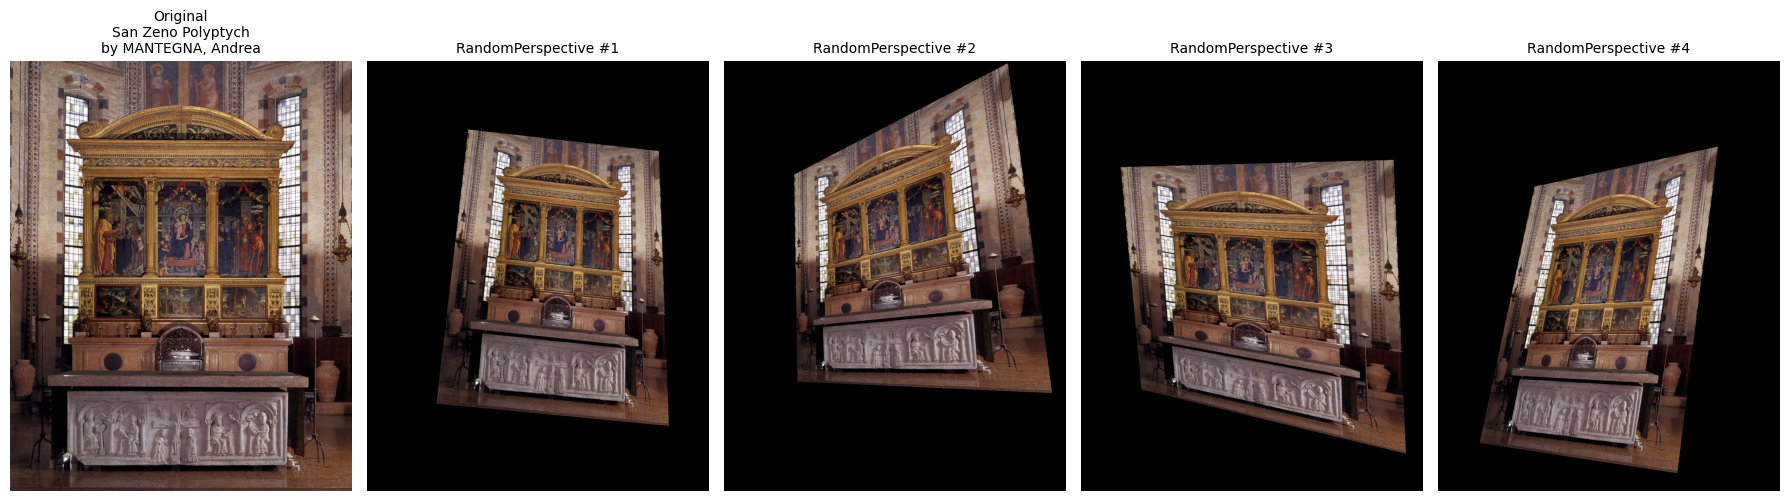


RandomPerspective transformation applied successfully!


In [42]:
import matplotlib.pyplot as plt
from PIL import Image
import os

from torchvision.transforms import v2

# Select a random painting from the dataset
random_painting = df_train.sample(n=1, random_state=42)
image_file = random_painting['IMAGE_FILE'].values[0]
title = random_painting['TITLE'].values[0]
author = random_painting['AUTHOR'].values[0]
image_path = os.path.join("Images", image_file)

print(f"Selected painting: {title}")
print(f"Author: {author}")
print(f"File: {image_file}")

# Load the image (IMPORTANT: convert to RGB)
original_image = Image.open(image_path).convert("RGB")

print(f"\nOriginal image size: {original_image.size}")

# Define RandomPerspective transform
perspective_transform = v2.RandomPerspective(
    distortion_scale=0.6,
    p=1.0
)

# Generate multiple perspective-transformed images
num_variants = 4
perspective_images = [
    perspective_transform(original_image) for _ in range(num_variants)
]

# Plot original + perspective variants
fig, axes = plt.subplots(1, num_variants + 1, figsize=(18, 5))

# Original
axes[0].imshow(original_image)
axes[0].set_title(f"Original\n{title}\nby {author}", fontsize=10)
axes[0].axis("off")

# Perspective variants
for i, img in enumerate(perspective_images, start=1):
    axes[i].imshow(img)
    axes[i].set_title(f"RandomPerspective #{i}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("\nRandomPerspective transformation applied successfully!")


In [43]:
def predict_author_for_perspective_image(
    image_path,
    authors_list,
    model,
    processor,
    device,
    distortion_scale=0.6
):
    """
    Apply RandomPerspective transform and predict author using CLIP
    """
    try:
        # Load image
        image = Image.open(image_path).convert("RGB")

        # Random perspective transform
        perspective_transform = v2.RandomPerspective(
            distortion_scale=distortion_scale,
            p=1.0
        )

        transformed_image = perspective_transform(image)

        # CLIP preprocessing
        inputs = processor(
            text=authors_list,
            images=transformed_image,
            return_tensors="pt",
            padding=True
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds = outputs.text_embeds

            similarity_scores = F.cosine_similarity(image_embeds, text_embeds)

        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()

        return best_author, best_score

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None


In [44]:
perspective_results = []

print(f"Re-predicting authors with RandomPerspective on {len(correct_predictions)} images...\n")
print("=" * 100)

total = len(correct_predictions)

for counter, result in enumerate(correct_predictions, 1):

    image_file = result['image_file']
    true_author = result['true_author']
    original_prediction = result['predicted_author']
    original_confidence = result['confidence']
    title = result['title']
    image_path = os.path.join("Images", image_file)

    if counter <= 10 or counter % 200 == 0:
        print(f"\n[{counter}/{total}] Processing: {title} by {true_author}")

    predicted_author, confidence = predict_author_for_perspective_image(
        image_path,
        top_100_authors,
        model,
        processor,
        device,
        distortion_scale=0.6
    )

    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"

        if counter <= 10 or counter % 200 == 0:
            print(f"   Original (color): ✅ {original_prediction} ({original_confidence:.4f})")
            print(f"   Perspective: {symbol} {predicted_author} ({confidence:.4f})")

        perspective_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'original_prediction': original_prediction,
            'original_confidence': original_confidence,
            'perspective_prediction': predicted_author,
            'perspective_confidence': confidence,
            'still_correct': is_correct
        })

print("\n\nRandomPerspective re-prediction complete!")


Re-predicting authors with RandomPerspective on 2339 images...


[1/2339] Processing: Ceiling vault (centre part) by CORTONA, Pietro da
   Original (color): ✅ CORTONA, Pietro da (0.3042)
   Perspective: ✅ CORTONA, Pietro da (0.2905)

[2/2339] Processing: Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna
   Original (color): ✅ DUCCIO di Buoninsegna (0.3085)
   Perspective: ❌ GIOTTO di Bondone (0.2962)

[3/2339] Processing: Samson and Delilah by CRANACH, Lucas the Elder
   Original (color): ✅ CRANACH, Lucas the Elder (0.3070)
   Perspective: ❌ PINTURICCHIO (0.3212)

[4/2339] Processing: What's New? (Parau Api) by GAUGUIN, Paul
   Original (color): ✅ GAUGUIN, Paul (0.3492)
   Perspective: ✅ GAUGUIN, Paul (0.2971)

[5/2339] Processing: Rest on Flight to Egypt by CARAVAGGIO
   Original (color): ✅ CARAVAGGIO (0.3111)
   Perspective: ✅ CARAVAGGIO (0.3112)

[6/2339] Processing: Reversible Head with Basket of Fruit by ARCIMBOLDO, Giuseppe
   Original (color): ✅ ARCIMBOLDO, Giuseppe (

In [45]:
perspective_df = pd.DataFrame(perspective_results)

perspective_accuracy = (
    perspective_df['still_correct'].sum() / len(perspective_df) * 100
)

print(f"\nRandomPerspective Accuracy: {perspective_accuracy:.2f}%")
print(f"Accuracy Drop: {100 - perspective_accuracy:.2f}%")

print(f"\nConfidence:")
print(f"  Original avg: {perspective_df['original_confidence'].mean():.4f}")
print(f"  Perspective avg: {perspective_df['perspective_confidence'].mean():.4f}")



RandomPerspective Accuracy: 59.90%
Accuracy Drop: 40.10%

Confidence:
  Original avg: 0.3183
  Perspective avg: 0.2984


In [46]:
# Comprehensive comparison of color vs RandomPerspective predictions
if perspective_results:
    perspective_results_df = pd.DataFrame(perspective_results)
    
    print("\n" + "="*100)
    print("RANDOM PERSPECTIVE vs COLOR PREDICTION COMPARISON")
    print("="*100)
    
    # Calculate accuracy on perspective images
    perspective_accuracy = (
        perspective_results_df['still_correct'].sum()
        / len(perspective_results_df) * 100
    )
    
    print(f"\nOriginal Color Images:")
    print(f"  Total paintings tested: {len(perspective_results_df)}")
    print(f"  All were correctly predicted: 100% (these were the correct predictions from original test)")
    
    print(f"\nRandomPerspective Images:")
    print(f"  Total paintings tested: {len(perspective_results_df)}")
    print(f"  Still correctly predicted: {perspective_results_df['still_correct'].sum()}")
    print(f"  Accuracy: {perspective_accuracy:.2f}%")
    
    # Calculate drop in accuracy
    accuracy_drop = 100 - perspective_accuracy
    print(f"\nAccuracy Drop: {accuracy_drop:.2f}%")
    print(
        f"  ({perspective_results_df['still_correct'].sum()}"
        f"/{len(perspective_results_df)} paintings remained correct after RandomPerspective)"
    )
    
    # Confidence comparison
    print(f"\nConfidence Statistics:")
    print(f"  Original (color) - Average: {perspective_results_df['original_confidence'].mean():.4f}")
    print(f"  RandomPerspective - Average: {perspective_results_df['perspective_confidence'].mean():.4f}")
    
    confidence_diff = (
        perspective_results_df['perspective_confidence'].mean()
        - perspective_results_df['original_confidence'].mean()
    )
    print(f"  Confidence change: {confidence_diff:+.4f}")
    
    # Analyze paintings that became incorrect
    became_incorrect = perspective_results_df[~perspective_results_df['still_correct']]
    
    if len(became_incorrect) > 0:
        print(
            f"\n\nPaintings that became INCORRECT after RandomPerspective "
            f"({len(became_incorrect)} total):"
        )
        print("-"*100)
        
        print(f"\nMost common new predictions (what model confused them with):")
        new_predictions = (
            became_incorrect['perspective_prediction']
            .value_counts()
            .head(10)
        )
        for author, count in new_predictions.items():
            print(f"  {author}: {count} paintings")
        
        print(f"\nAuthors most affected by RandomPerspective (lost correct predictions):")
        affected_authors = became_incorrect['true_author'].value_counts().head(10)
        for author, count in affected_authors.items():
            total_by_author = len(
                perspective_results_df[
                    perspective_results_df['true_author'] == author
                ]
            )
            print(
                f"  {author}: {count}/{total_by_author} became incorrect "
                f"({count/total_by_author*100:.1f}%)"
            )
        
        print(f"\nSample of paintings that lost correct prediction:")
        display(
            became_incorrect[
                [
                    'title',
                    'true_author',
                    'original_prediction',
                    'perspective_prediction',
                    'original_confidence',
                    'perspective_confidence'
                ]
            ].head(20)
        )
    
    # Paintings that remained correct
    remained_correct = perspective_results_df[perspective_results_df['still_correct']]
    
    if len(remained_correct) > 0:
        print(
            f"\n\nPaintings that remained CORRECT after RandomPerspective "
            f"({len(remained_correct)} total):"
        )
        print("-"*100)
        
        print(f"\nAuthors most robust to RandomPerspective:")
        robust_authors = remained_correct['true_author'].value_counts().head(10)
        for author, count in robust_authors.items():
            total_by_author = len(
                perspective_results_df[
                    perspective_results_df['true_author'] == author
                ]
            )
            print(
                f"  {author}: {count}/{total_by_author} remained correct "
                f"({count/total_by_author*100:.1f}%)"
            )
        
        print(f"\nSample of paintings that remained correct:")
        display(
            remained_correct[
                [
                    'title',
                    'true_author',
                    'original_confidence',
                    'perspective_confidence'
                ]
            ].head(20)
        )
    
    print("\n\nAll Results (first 50 rows):")
    display(
        perspective_results_df[
            [
                'title',
                'true_author',
                'original_prediction',
                'perspective_prediction',
                'original_confidence',
                'perspective_confidence',
                'still_correct'
            ]
        ].head(50)
    )

else:
    print("No results to display.")



RANDOM PERSPECTIVE vs COLOR PREDICTION COMPARISON

Original Color Images:
  Total paintings tested: 2339
  All were correctly predicted: 100% (these were the correct predictions from original test)

RandomPerspective Images:
  Total paintings tested: 2339
  Still correctly predicted: 1401
  Accuracy: 59.90%

Accuracy Drop: 40.10%
  (1401/2339 paintings remained correct after RandomPerspective)

Confidence Statistics:
  Original (color) - Average: 0.3183
  RandomPerspective - Average: 0.2984
  Confidence change: -0.0199


Paintings that became INCORRECT after RandomPerspective (938 total):
----------------------------------------------------------------------------------------------------

Most common new predictions (what model confused them with):
  PINTURICCHIO: 128 paintings
  TINTORETTO: 69 paintings
  PERUGINO, Pietro: 60 paintings
  FRAGONARD, Jean-Honoré: 45 paintings
  MANTEGNA, Andrea: 40 paintings
  SIMONE MARTINI: 34 paintings
  GIOTTO di Bondone: 31 paintings
  UCCELLO, Pa

,title,true_author,original_prediction,perspective_prediction,original_confidence,perspective_confidence
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.308452,0.296165
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",PINTURICCHIO,0.307020,0.321210
6,The Flight into Egypt,TINTORETTO,TINTORETTO,"FRAGONARD, Jean-Honoré",0.331606,0.316530
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304792,0.308775
12,Assumption of the Virgin,TINTORETTO,TINTORETTO,"VERONESE, Paolo",0.333987,0.299366
14,The Watzmann,"FRIEDRICH, Caspar David","FRIEDRICH, Caspar David","RUYSDAEL, Salomon van",0.294781,0.245939
16,The Two Trinities,"MURILLO, Bartolomé Esteban","MURILLO, Bartolomé Esteban","RUBENS, Peter Paul",0.301006,0.257255
21,The Gallery of Archduke Leopold in Brussels,"TENIERS, David the Younger","TENIERS, David the Younger",PINTURICCHIO,0.285671,0.285926
22,Woman with a Parasol in a Garden,"RENOIR, Pierre-Auguste","RENOIR, Pierre-Auguste","MONET, Claude",0.326936,0.286642
24,Perugino's Self-Portrait,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.318418,0.284651




Paintings that remained CORRECT after RandomPerspective (1401 total):
----------------------------------------------------------------------------------------------------

Authors most robust to RandomPerspective:
  GOGH, Vincent van: 132/160 remained correct (82.5%)
  CANALETTO: 81/84 remained correct (96.4%)
  REMBRANDT Harmenszoon van Rijn: 69/126 remained correct (54.8%)
  TINTORETTO: 65/102 remained correct (63.7%)
  CARAVAGGIO: 64/74 remained correct (86.5%)
  GAUGUIN, Paul: 57/74 remained correct (77.0%)
  GIOTTO di Bondone: 49/112 remained correct (43.8%)
  TOULOUSE-LAUTREC, Henri de: 47/62 remained correct (75.8%)
  CÉZANNE, Paul: 44/70 remained correct (62.9%)
  RUBENS, Peter Paul: 43/110 remained correct (39.1%)

Sample of paintings that remained correct:


,title,true_author,original_confidence,perspective_confidence
0,Ceiling vault (centre part),"CORTONA, Pietro da",0.304181,0.290492
3,What's New? (Parau Api),"GAUGUIN, Paul",0.349215,0.297132
4,Rest on Flight to Egypt,CARAVAGGIO,0.311075,0.311157
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe",0.417589,0.385038
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de",0.321606,0.246786
9,Flagellation,CARAVAGGIO,0.332341,0.317043
10,Dance in the Moulin de la Galette,"RENOIR, Pierre-Auguste",0.353137,0.309282
11,Luncheon on the Grass (Le Déjeuner sur l'herbe),"MANET, Edouard",0.305351,0.296343
13,St John Altarpiece (closed),"MEMLING, Hans",0.316869,0.309113
15,The Prophet Solomon (prophet 3),DUCCIO di Buoninsegna,0.325388,0.310774




All Results (first 50 rows):


,title,true_author,original_prediction,perspective_prediction,original_confidence,perspective_confidence,still_correct
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da","CORTONA, Pietro da",0.304181,0.290492,True
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,GIOTTO di Bondone,0.308452,0.296165,False
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder",PINTURICCHIO,0.307020,0.321210,False
3,What's New? (Parau Api),"GAUGUIN, Paul","GAUGUIN, Paul","GAUGUIN, Paul",0.349215,0.297132,True
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,CARAVAGGIO,0.311075,0.311157,True
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe",0.417589,0.385038,True
6,The Flight into Egypt,TINTORETTO,TINTORETTO,"FRAGONARD, Jean-Honoré",0.331606,0.316530,False
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304792,0.308775,False
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de",0.321606,0.246786,True
9,Flagellation,CARAVAGGIO,CARAVAGGIO,CARAVAGGIO,0.332341,0.317043,True


In [47]:
# Function to predict author for an elastic-transformed image
def predict_author_for_elastic_image(image_path, authors_list, model, processor, device, alpha=250.0, sigma=5.0):
    """
    Apply elastic transformation and predict the author of a painting using CLIP similarity
    """
    try:
        # Load the image
        image = Image.open(image_path)
        
        # Apply elastic transformation
        elastic_transform = transforms.ElasticTransform(alpha=alpha, sigma=sigma)
        elastic_image = elastic_transform(image)
        
        # Preprocess inputs
        inputs = processor(text=authors_list, images=elastic_image, return_tensors="pt", padding=True)
        
        # Move all input tensors to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run the model
        outputs = model(**inputs)
        image_embeddings = outputs.image_embeds
        text_embeddings = outputs.text_embeds
        
        # Compute similarity
        similarity_scores = F.cosine_similarity(image_embeddings, text_embeddings)
        
        # Get best match
        best_idx = similarity_scores.argmax().item()
        best_author = authors_list[best_idx]
        best_score = similarity_scores[best_idx].item()
        
        return best_author, best_score
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

print("Elastic transform prediction function defined successfully!")

Elastic transform prediction function defined successfully!


In [48]:
# Load the results from CSV and filter for correct predictions
correct_predictions_df = pd.read_csv("top100_results_df.csv")
correct_predictions_df = correct_predictions_df[correct_predictions_df['correct'] == True]

# Convert to list of dictionaries for compatibility with existing code
correct_predictions = correct_predictions_df.to_dict('records')

print(f"Total correct predictions loaded from CSV: {len(correct_predictions)}")
print(f"\nFirst 5 correct predictions:")
for i, pred in enumerate(correct_predictions[:5], 1):
    print(f"{i}. {pred['title']} by {pred['true_author']} (confidence: {pred['confidence']:.4f})")

Total correct predictions loaded from CSV: 2339

First 5 correct predictions:
1. Ceiling vault (centre part) by CORTONA, Pietro da (confidence: 0.3042)
2. Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna (confidence: 0.3085)
3. Samson and Delilah by CRANACH, Lucas the Elder (confidence: 0.3070)
4. What's New? (Parau Api) by GAUGUIN, Paul (confidence: 0.3492)
5. Rest on Flight to Egypt by CARAVAGGIO (confidence: 0.3111)


In [49]:
# Re-predict authors on elastic-transformed versions of correctly predicted images
elastic_results = []

print(f"Re-predicting authors on {len(correct_predictions)} elastic-transformed images...\n")
print(f"Using ElasticTransform with alpha=250.0, sigma=5.0")
print("="*100)

total = len(correct_predictions)
for counter, result in enumerate(correct_predictions, 1):
    
    image_file = result['image_file']
    true_author = result['true_author']
    original_prediction = result['predicted_author']
    original_confidence = result['confidence']
    title = result['title']
    image_path = os.path.join("Images", image_file)
    
    # Show progress every 200 paintings or for first 10
    if counter <= 10 or counter % 200 == 0:
        print(f"\n[{counter}/{total}] Processing: {title} by {true_author}")
    
    # Predict author on elastic-transformed image
    predicted_author, confidence = predict_author_for_elastic_image(
        image_path, top_100_authors, model, processor, device, alpha=250.0, sigma=5.0
    )
    
    if predicted_author:
        is_correct = predicted_author == true_author
        symbol = "✅" if is_correct else "❌"
        
        # Only show detailed predictions for first 10 or every 200th painting
        if counter <= 10 or counter % 200 == 0:
            print(f"   Original (no transform): ✅ {original_prediction} (confidence: {original_confidence:.4f})")
            print(f"   Elastic transform: {symbol} {predicted_author} (confidence: {confidence:.4f})")
        
        elastic_results.append({
            'image_file': image_file,
            'title': title,
            'true_author': true_author,
            'original_prediction': original_prediction,
            'original_confidence': original_confidence,
            'elastic_prediction': predicted_author,
            'elastic_confidence': confidence,
            'still_correct': is_correct
        })

print(f"\n\nElastic transform re-prediction complete!")

Re-predicting authors on 2339 elastic-transformed images...

Using ElasticTransform with alpha=250.0, sigma=5.0

[1/2339] Processing: Ceiling vault (centre part) by CORTONA, Pietro da
   Original (no transform): ✅ CORTONA, Pietro da (confidence: 0.3042)
   Elastic transform: ✅ CORTONA, Pietro da (confidence: 0.2860)

[2/2339] Processing: Christ Before King Herod (scene 14) by DUCCIO di Buoninsegna
   Original (no transform): ✅ DUCCIO di Buoninsegna (confidence: 0.3085)
   Elastic transform: ✅ DUCCIO di Buoninsegna (confidence: 0.2975)

[3/2339] Processing: Samson and Delilah by CRANACH, Lucas the Elder
   Original (no transform): ✅ CRANACH, Lucas the Elder (confidence: 0.3070)
   Elastic transform: ❌ CORTONA, Pietro da (confidence: 0.3031)

[4/2339] Processing: What's New? (Parau Api) by GAUGUIN, Paul
   Original (no transform): ✅ GAUGUIN, Paul (confidence: 0.3492)
   Elastic transform: ✅ GAUGUIN, Paul (confidence: 0.3223)

[5/2339] Processing: Rest on Flight to Egypt by CARAVAGGIO
   

In [50]:
# Comprehensive comparison: Original vs Elastic Transform
if elastic_results:
    elastic_results_df = pd.DataFrame(elastic_results)
    
    print("\n" + "="*100)
    print("ELASTIC TRANSFORM vs ORIGINAL PREDICTION COMPARISON")
    print("="*100)
    
    # Calculate accuracy on elastic-transformed images
    elastic_accuracy = elastic_results_df['still_correct'].sum() / len(elastic_results_df) * 100
    
    print(f"\nOriginal Images (no transformation):")
    print(f"  Total paintings tested: {len(elastic_results_df)}")
    print(f"  All were correctly predicted: 100% (these were the correct predictions from original test)")
    
    print(f"\nElastic-Transformed Images (alpha=250.0, sigma=5.0):")
    print(f"  Total paintings tested: {len(elastic_results_df)}")
    print(f"  Still correctly predicted: {elastic_results_df['still_correct'].sum()}")
    print(f"  Accuracy: {elastic_accuracy:.2f}%")
    
    # Calculate drop in accuracy
    accuracy_drop = 100 - elastic_accuracy
    print(f"\nAccuracy Drop: {accuracy_drop:.2f}%")
    print(f"  ({elastic_results_df['still_correct'].sum()}/{len(elastic_results_df)} paintings remained correct after elastic transform)")
    
    # Confidence comparison
    print(f"\nConfidence Statistics:")
    print(f"  Original (no transform) - Average: {elastic_results_df['original_confidence'].mean():.4f}")
    print(f"  Elastic transform - Average: {elastic_results_df['elastic_confidence'].mean():.4f}")
    
    confidence_diff = elastic_results_df['elastic_confidence'].mean() - elastic_results_df['original_confidence'].mean()
    print(f"  Confidence change: {confidence_diff:+.4f}")
    
    # Compare with grayscale results if available
    if 'grayscale_results_df' in globals():
        print(f"\n\nComparison with Grayscale Transformation:")
        print(f"  Grayscale accuracy: {(grayscale_results_df['still_correct'].sum() / len(grayscale_results_df) * 100):.2f}%")
        print(f"  Elastic accuracy: {elastic_accuracy:.2f}%")
        elastic_vs_gray = elastic_accuracy - (grayscale_results_df['still_correct'].sum() / len(grayscale_results_df) * 100)
        print(f"  Elastic is {elastic_vs_gray:+.2f}% {'better' if elastic_vs_gray > 0 else 'worse'} than grayscale")
    
    # Analyze paintings that became incorrect
    became_incorrect_elastic = elastic_results_df[~elastic_results_df['still_correct']]
    
    if len(became_incorrect_elastic) > 0:
        print(f"\n\nPaintings that became INCORRECT after elastic transform ({len(became_incorrect_elastic)} total):")
        print("-"*100)
        
        print(f"\nMost common new predictions (what model confused them with):")
        new_predictions_elastic = became_incorrect_elastic['elastic_prediction'].value_counts().head(10)
        for author, count in new_predictions_elastic.items():
            print(f"  {author}: {count} paintings")
        
        print(f"\nAuthors most affected by elastic transform (lost correct predictions):")
        affected_authors_elastic = became_incorrect_elastic['true_author'].value_counts().head(10)
        for author, count in affected_authors_elastic.items():
            total_by_author = len(elastic_results_df[elastic_results_df['true_author'] == author])
            print(f"  {author}: {count}/{total_by_author} became incorrect ({count/total_by_author*100:.1f}%)")
        
        print(f"\nSample of paintings that lost correct prediction:")
        display(became_incorrect_elastic[['title', 'true_author', 'original_prediction', 'elastic_prediction', 
                                           'original_confidence', 'elastic_confidence']].head(20))
    
    # Paintings that remained correct
    remained_correct_elastic = elastic_results_df[elastic_results_df['still_correct']]
    
    if len(remained_correct_elastic) > 0:
        print(f"\n\nPaintings that remained CORRECT after elastic transform ({len(remained_correct_elastic)} total):")
        print("-"*100)
        
        print(f"\nAuthors most robust to elastic transform:")
        robust_authors_elastic = remained_correct_elastic['true_author'].value_counts().head(10)
        for author, count in robust_authors_elastic.items():
            total_by_author = len(elastic_results_df[elastic_results_df['true_author'] == author])
            print(f"  {author}: {count}/{total_by_author} remained correct ({count/total_by_author*100:.1f}%)")
        
        print(f"\nSample of paintings that remained correct:")
        display(remained_correct_elastic[['title', 'true_author', 'original_confidence', 'elastic_confidence']].head(20))
    
    # Side-by-side comparison of transformations
    if 'grayscale_results_df' in globals():
        print(f"\n\nSide-by-Side Comparison: Grayscale vs Elastic Transform")
        print("="*100)
        
        # Find paintings that failed in both
        gray_failed = set(grayscale_results_df[~grayscale_results_df['still_correct']]['image_file'])
        elastic_failed = set(elastic_results_df[~elastic_results_df['still_correct']]['image_file'])
        
        both_failed = gray_failed & elastic_failed
        only_gray_failed = gray_failed - elastic_failed
        only_elastic_failed = elastic_failed - gray_failed
        
        print(f"\nFailure patterns:")
        print(f"  Failed in BOTH transformations: {len(both_failed)} paintings")
        print(f"  Failed ONLY in grayscale: {len(only_gray_failed)} paintings")
        print(f"  Failed ONLY in elastic: {len(only_elastic_failed)} paintings")
        print(f"\nInterpretation:")
        print(f"  - Paintings that fail in both are likely highly sensitive to any distortion")
        print(f"  - Paintings that fail only in grayscale rely heavily on color information")
        print(f"  - Paintings that fail only in elastic are sensitive to geometric distortions but not color")
    
    print("\n\nAll Results (first 50 rows):")
    display(elastic_results_df[['title', 'true_author', 'original_prediction', 'elastic_prediction', 
                                 'original_confidence', 'elastic_confidence', 'still_correct']].head(50))

else:
    print("No results to display.")


ELASTIC TRANSFORM vs ORIGINAL PREDICTION COMPARISON

Original Images (no transformation):
  Total paintings tested: 2339
  All were correctly predicted: 100% (these were the correct predictions from original test)

Elastic-Transformed Images (alpha=250.0, sigma=5.0):
  Total paintings tested: 2339
  Still correctly predicted: 941
  Accuracy: 40.23%

Accuracy Drop: 59.77%
  (941/2339 paintings remained correct after elastic transform)

Confidence Statistics:
  Original (no transform) - Average: 0.3183
  Elastic transform - Average: 0.3075
  Confidence change: -0.0108


Comparison with Grayscale Transformation:
  Grayscale accuracy: 65.28%
  Elastic accuracy: 40.23%
  Elastic is -25.05% worse than grayscale


Paintings that became INCORRECT after elastic transform (1398 total):
----------------------------------------------------------------------------------------------------

Most common new predictions (what model confused them with):
  FRAGONARD, Jean-Honoré: 260 paintings
  GOYA Y 

,title,true_author,original_prediction,elastic_prediction,original_confidence,elastic_confidence
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder","CORTONA, Pietro da",0.307020,0.303056
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,"FRAGONARD, Jean-Honoré",0.311075,0.345640
6,The Flight into Egypt,TINTORETTO,TINTORETTO,"FRAGONARD, Jean-Honoré",0.331606,0.324514
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304792,0.299506
9,Flagellation,CARAVAGGIO,CARAVAGGIO,"GOYA Y LUCIENTES, Francisco de",0.332341,0.314693
13,St John Altarpiece (closed),"MEMLING, Hans","MEMLING, Hans",PINTURICCHIO,0.316869,0.273750
14,The Watzmann,"FRIEDRICH, Caspar David","FRIEDRICH, Caspar David","GUARDI, Francesco",0.294781,0.276540
16,The Two Trinities,"MURILLO, Bartolomé Esteban","MURILLO, Bartolomé Esteban","FRAGONARD, Jean-Honoré",0.301006,0.330132
17,Triptych of Haywain (central panel),"BOSCH, Hieronymus","BOSCH, Hieronymus","BRUEGEL, Pieter the Elder",0.298201,0.290887
18,The Ship of Fools,"BOSCH, Hieronymus","BOSCH, Hieronymus","GOYA Y LUCIENTES, Francisco de",0.328656,0.323845




Paintings that remained CORRECT after elastic transform (941 total):
----------------------------------------------------------------------------------------------------

Authors most robust to elastic transform:
  REMBRANDT Harmenszoon van Rijn: 88/126 remained correct (69.8%)
  GOGH, Vincent van: 65/160 remained correct (40.6%)
  CÉZANNE, Paul: 58/70 remained correct (82.9%)
  MONET, Claude: 58/61 remained correct (95.1%)
  GAUGUIN, Paul: 50/74 remained correct (67.6%)
  TOULOUSE-LAUTREC, Henri de: 43/62 remained correct (69.4%)
  RENOIR, Pierre-Auguste: 40/45 remained correct (88.9%)
  TINTORETTO: 40/102 remained correct (39.2%)
  FRAGONARD, Jean-Honoré: 33/34 remained correct (97.1%)
  CRANACH, Lucas the Elder: 30/82 remained correct (36.6%)

Sample of paintings that remained correct:


,title,true_author,original_confidence,elastic_confidence
0,Ceiling vault (centre part),"CORTONA, Pietro da",0.304181,0.285990
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,0.308452,0.297523
3,What's New? (Parau Api),"GAUGUIN, Paul",0.349215,0.322304
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe",0.417589,0.413742
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de",0.321606,0.304008
10,Dance in the Moulin de la Galette,"RENOIR, Pierre-Auguste",0.353137,0.313671
11,Luncheon on the Grass (Le Déjeuner sur l'herbe),"MANET, Edouard",0.305351,0.309032
12,Assumption of the Virgin,TINTORETTO,0.333987,0.322262
15,The Prophet Solomon (prophet 3),DUCCIO di Buoninsegna,0.325388,0.294477
19,Love as Folly,"FRAGONARD, Jean-Honoré",0.353358,0.339863




Side-by-Side Comparison: Grayscale vs Elastic Transform

Failure patterns:
  Failed in BOTH transformations: 585 paintings
  Failed ONLY in grayscale: 227 paintings
  Failed ONLY in elastic: 813 paintings

Interpretation:
  - Paintings that fail in both are likely highly sensitive to any distortion
  - Paintings that fail only in grayscale rely heavily on color information
  - Paintings that fail only in elastic are sensitive to geometric distortions but not color


All Results (first 50 rows):


,title,true_author,original_prediction,elastic_prediction,original_confidence,elastic_confidence,still_correct
0,Ceiling vault (centre part),"CORTONA, Pietro da","CORTONA, Pietro da","CORTONA, Pietro da",0.304181,0.285990,True
1,Christ Before King Herod (scene 14),DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,DUCCIO di Buoninsegna,0.308452,0.297523,True
2,Samson and Delilah,"CRANACH, Lucas the Elder","CRANACH, Lucas the Elder","CORTONA, Pietro da",0.307020,0.303056,False
3,What's New? (Parau Api),"GAUGUIN, Paul","GAUGUIN, Paul","GAUGUIN, Paul",0.349215,0.322304,True
4,Rest on Flight to Egypt,CARAVAGGIO,CARAVAGGIO,"FRAGONARD, Jean-Honoré",0.311075,0.345640,False
5,Reversible Head with Basket of Fruit,"ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe","ARCIMBOLDO, Giuseppe",0.417589,0.413742,True
6,The Flight into Egypt,TINTORETTO,TINTORETTO,"FRAGONARD, Jean-Honoré",0.331606,0.324514,False
7,Trinity and Six Saints,"PERUGINO, Pietro","PERUGINO, Pietro",GIOTTO di Bondone,0.304792,0.299506,False
8,At the Moulin Rouge,"TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de","TOULOUSE-LAUTREC, Henri de",0.321606,0.304008,True
9,Flagellation,CARAVAGGIO,CARAVAGGIO,"GOYA Y LUCIENTES, Francisco de",0.332341,0.314693,False


In [51]:
grayscale_results_df.to_csv("grayscale_results_df.csv", index=False)
perspective_results_df.to_csv("perspective_results_df.csv", index=False)
elastic_results_df.to_csv("elastic_results_df.csv", index=False)